In [12]:
%pip install unsupervised_absa

Note: you may need to restart the kernel to use updated packages.


# Overall Pipeline

1. Diagram
2. Explaination of the pipeline

# Dataset sample

### Data loading

In this section, any dataset can be used. Including dataset that doesn't have any aspect terms or categories, and dataset that doesn't have polarity. For this example, we will used an existing dataset for aspect based sentiment analysis called semeval2014 task 4 which include aspect terms and categories analysis.

In [14]:
# Load dataset from huggingface
from datasets import load_dataset
train_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='train')
validation_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='validation')
test_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='test')

No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (/Users/stevenlimcorn/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f)
No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (/Users/stevenlimcorn/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f)
No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (/Users/stevenlimcorn/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f)


The test dataset doesn't have any polarity but it does have terms and categories.

# Preprocessing

Next will be preprocessing the data. In this sample, most of the text dataset are pretty cleaned. But for the sake of this demo, we will clean it anyways.

In [15]:
from unsupervised_absa.preprocess import simple_preprocessing
from datasets import Dataset

In [16]:
# preprocessing currently only supports pandas.series, list, and numpy
train_df = train_dataset.to_pandas()
train_df['text'] = simple_preprocessing(train_df['text'])
preprocessed_dataset = Dataset.from_pandas(train_df)

Processing strip_spaces: 100%|██████████| 11/11 [00:00<00:00, 65.61it/s]         


The processes in the preprocessing pipeline include:
1. encode decode
2. convert_unicode
3. remove_url
4. remove_control_characters
5. remove_tags
6. remove_emoji
7. convert_contractions
8. remove_numbers
9. remove_punctuation
10. remove_multiple_spaces
11. strip_spaces

# Pos Tagging

The purpose of pos tagging to get the potential aspect terms in each sentence. For sentences without aspects being detect will be directed to the sentence embedding extraction section.
The pos tagging model used here is from [Flair](https://github.com/flairNLP/flair), a library to perform NLP processing. This project revolves around using this library.

In [4]:
from unsupervised_absa.tagger import Tagger
tagger = Tagger('pos', device='cpu')
preprocessed_df = preprocessed_dataset.to_pandas()
preprocessed_df['pos_tag'] = tagger.tagging(preprocessed_df['text'], filter_tags=["NN", "NNS"])

2023-04-03 23:24:12,299 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


2023-04-03 23:24:12.456 | INFO     | unsupervised_absa.tagger:__init__:32 - Tagger model instantiated with device: cpu
2023-04-03 23:24:12.466 | INFO     | unsupervised_absa.tagger:tagging:38 - Extracting pos tags
100%|██████████| 6086/6086 [26:57<00:00,  3.76it/s] 


In [5]:
# save postag results in a json file: list of dictionaries
import json
pos_tags = preprocessed_df.drop(columns=['aspectTerms', 'aspectCategories', 'domain']).to_dict('records')
with open("data/semeval_pos_tag.json", "w") as fp:
    json.dump(pos_tags, fp) 

Performing these pos tags for nouns will give us the candidate terms. 

100%|██████████| 6086/6086 [00:00<00:00, 2115926.24it/s]


<Axes: title={'center': 'Top k Most Frequent Words'}>

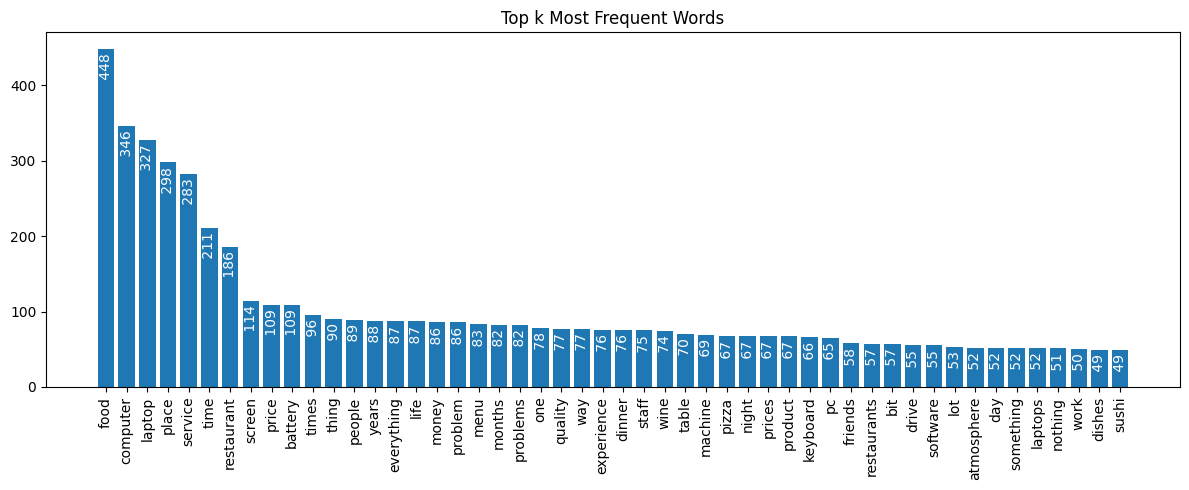

In [2]:
from tqdm import tqdm
from unsupervised_absa.preprocess import plot_top_k_words
import json

with open('data/semeval_pos_tag.json') as f:
    pos_tags = json.load(f)

list_of_words = []
for row in tqdm(pos_tags):
    for pos_data in row['pos_tag']:
        list_of_words.append(pos_data['word'])
plot_top_k_words(list_of_words, 50)

# Extract Embeddings

This section is used to extract the word embeddings of each nouns that are tagged from pos tagging process. These terms will be clustered to get the specific domain they are in.

In [3]:
# get the list of words, remove all the 
list_of_words = list(set(list_of_words))

### Bert base

In [4]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
bert_embedding = ExtractEmbedding(ModelType.TRANSFORMER_WORD, 'bert-base-uncased')

In [5]:
bert_embedding_data = bert_embedding.extract(list_of_words)

100%|██████████| 3384/3384 [02:33<00:00, 22.11it/s]


In [6]:
import numpy as np
np.save('data/sem_eval_bert_embedding.npy', bert_embedding_data)

### Glove

In [7]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
glove_embedding = ExtractEmbedding(ModelType.WORD, 'glove')

In [8]:
glove_embedding_data = glove_embedding.extract(list_of_words)

100%|██████████| 3384/3384 [00:00<00:00, 20340.30it/s]


In [9]:
import numpy as np
np.save('data/sem_eval_glove_embedding.npy', glove_embedding_data)

### Word2Vec

Word2Vec is not in flair, what we can do is convert from gensim to flair

### Training word2vec

In [18]:
import gensim
# to make sure our dataset are preprocessed accordingly to gensim, we need to use gensim preproess
preprocessed_df = preprocessed_dataset.to_pandas()
training_text = preprocessed_df['text'].progress_apply(gensim.utils.simple_preprocess)

100%|██████████| 6086/6086 [00:00<00:00, 96747.49it/s]


In [19]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
model = gensim.models.Word2Vec(
    window=10,
    min_count=0,
#     sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=0,
    workers=cores-1
)

In [21]:
model.build_vocab(training_text, progress_per=10)
from time import time  # To time our operations
t = time()

model.train(training_text, total_examples=model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


In [23]:
model.save("./models/word2vec-semeval.model")

In [25]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
word2vec_embedding = ExtractEmbedding(ModelType.WORD, './models/word2vec-semeval.model')

AttributeError: 'Word2Vec' object has no attribute 'vectors'

In [ ]:
word2vec_embedding_data = word2vec_embedding.extract(list_of_words)

100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


tensor([[-0.0410,  0.0396,  0.3214,  ..., -0.2888,  0.3112,  0.0432],
        [-0.0410,  0.0396,  0.3214,  ..., -0.2888,  0.3112,  0.0432]])

In [ ]:
import numpy as np
np.save('data/sem_eval_word2vec_embedding.npy', word2vec_embedding_data)

### Stacked Embedding

In [ ]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
stacked_embedding = ExtractEmbedding([ModelType.TRANSFORMER_WORD, ModelType.WORD, ModelType.WORD,], ['bert-base-uncased', 'glove', 'word2vec'])

In [ ]:
stackstacked_embedding_data = stacked_embedding.extract(list_of_words)

In [ ]:
import numpy as np
np.save('data/sem_eval_stacked_embedding.npy', )

# Clustering

In [ ]:
from unsupervised_absa.clustering import ClusteringModel
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)

clustering_model = ClusteringModel(
    model=model
)

In [10]:
clustering_model.fit(embeddings=embedding_data)

2023-03-23 15:03:53.939 | INFO     | unsupervised_absa.clustering:fit:46 - Start clustering KMeans(n_clusters=2) with 2 Datapoints.
2023-03-23 15:03:53.941 | INFO     | unsupervised_absa.clustering:fit:53 - (2, 1536)
/opt/miniconda3/envs/ABSA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2023-03-23 15:03:54.430 | INFO     | unsupervised_absa.clustering:fit:55 - Finished clustering.


In [11]:
from sklearn.cluster import Birch
model = Birch(n_clusters=6)

clustering_model = ClusteringModel(
    model=model,
)

# fit the model on a corpus
clustering_model.fit(embedding_data)

2023-03-23 15:03:54.460 | INFO     | unsupervised_absa.clustering:fit:46 - Start clustering Birch(n_clusters=6) with 2 Datapoints.
2023-03-23 15:03:54.461 | INFO     | unsupervised_absa.clustering:fit:53 - (2, 1536)
/opt/miniconda3/envs/ABSA/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
2023-03-23 15:03:54.508 | INFO     | unsupervised_absa.clustering:fit:55 - Finished clustering.


In [12]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=6)

clustering_model = ClusteringModel(
    model=model,
)

# fit the model on a corpus
clustering_model.fit(embedding_data)

# MNLI

In [19]:
%pip install unsupervised_absa

Note: you may need to restart the kernel to use updated packages.


In [1]:
from datasets import concatenate_datasets, load_dataset
train_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='train')

No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (/Users/stevenlimcorn/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f)


In [2]:
# 1. Convert datasets of semeval (expand the categories to different entries) datasets to df
train_dataset.set_format("pandas")
train_dataset = train_dataset.filter(lambda x: len(x['aspectTerms']) != 0)[:]

Loading cached processed dataset at /Users/stevenlimcorn/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f/cache-fb60e195c5b3dd16.arrow


In [3]:
from tqdm import tqdm
import pandas as pd
new_df = {'text': [], 'sid': [], 'aspectLabel': []}
for index, row in tqdm(train_dataset.iterrows()):
    text = row['text']
    sid = row['sentenceId']
    for aspect in row['aspectTerms']:
        new_df['aspectLabel'].append(aspect['term'])
        new_df['text'].append(text)
        new_df['sid'].append(sid)

preprocessed_df = pd.DataFrame(new_df)

3509it [00:00, 56160.07it/s]


In [4]:
from datasets import Dataset
preprocessed_dataset = Dataset.from_pandas(preprocessed_df)

In [5]:
from unsupervised_absa.mnli import MnliPipeline
model = MnliPipeline('microsoft/deberta-large-mnli')

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# for batch in [8, 16, 32, 64, 128]:
dataset = model.extract_polarity(preprocessed_dataset, 'text', 'aspectLabel', device='mps', batch_size=8)

2023-04-03 16:58:39.346 | INFO     | unsupervised_absa.mnli:extract_polarity:146 - Preprocessing dataset with length: 31
2023-04-03 16:58:39.354 | INFO     | unsupervised_absa.mnli:extract_polarity:150 - Extracting polarity with model: microsoft/deberta-large-mnli
100%|██████████| 31/31 [00:09<00:00,  3.25it/s]
2023-04-03 16:58:48.927 | INFO     | unsupervised_absa.mnli:extract_polarity:169 - Postprocessing outputs


In [8]:
stats = {'a': 5, 'b': 2}
max(stats, key=stats.get)


'a'

In [11]:
def _get_polarity_term(output: dict):
    processed = {}
    term = None
    for label, score in zip(output["labels"], output["scores"]):
        # sample: This example is negative sentiment towards staff.
        polarity, term = (
            label.replace("This example is ", "")
            .replace(" sentiment towards", "")
            .replace(".", "")
            .split()
        )
        term = term
        processed[polarity] = score
    # argmax of previously extracted polarity
    processed["polarity"] = max(processed, key=processed.get)
    processed["term"] = term
    return processed

In [12]:
_get_polarity_term({'sequence': 'But the staff was so horrible to us.', 'labels': ['This example is negative sentiment towards staff.', 'This example is positive sentiment towards staff.', 'This example is neutral sentiment towards staff.'], 'scores': [0.992158055305481, 0.004752019420266151, 0.0030899278353899717]})

{'negative': 0.992158055305481,
 'positive': 0.004752019420266151,
 'neutral': 0.0030899278353899717,
 'polarity': 'negative',
 'term': 'staff'}